In [689]:
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostRegressor
from matplotlib import pyplot
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 15, 5

## Data load

In [519]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [520]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21648 entries, 0 to 21647
Data columns (total 6 columns):
Province/State    6724 non-null object
Country/Region    21648 non-null object
Lat               21648 non-null float64
Long              21648 non-null float64
Date              21648 non-null datetime64[ns]
Confirmed         21648 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1014.9+ KB


In [521]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(21648, 6)

In [522]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [523]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [524]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [525]:
df.head()

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1


In [526]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [527]:
len(df['Province_and_country'].unique())

265

In [528]:
len(df['Country'].unique())

186

In [529]:
len(df['Province'].unique())

83

In [530]:
df.describe()

,Confirmed,Lat,Long,Days_since_outbreak_global
count,21730.00,21648.00,21648.00,21730.00
mean,2513.01,21.32,22.17,41.50
std,38189.64,24.69,70.54,23.67
min,-1.00,-51.80,-135.00,1.00
25%,0.00,6.97,-20.03,21.00
50%,1.00,23.49,20.54,41.50
75%,93.00,41.17,78.75,62.00
max,1846679.00,71.71,178.06,82.00


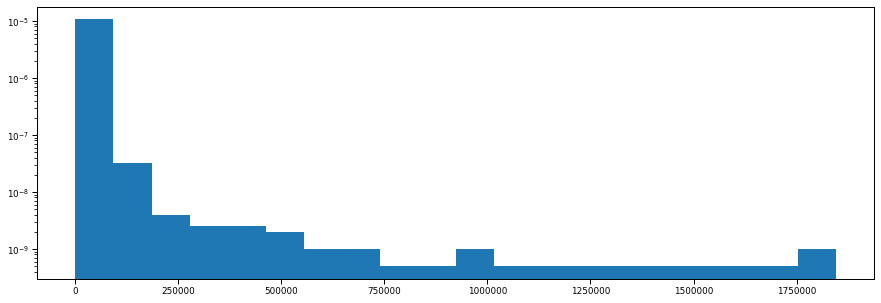

In [531]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

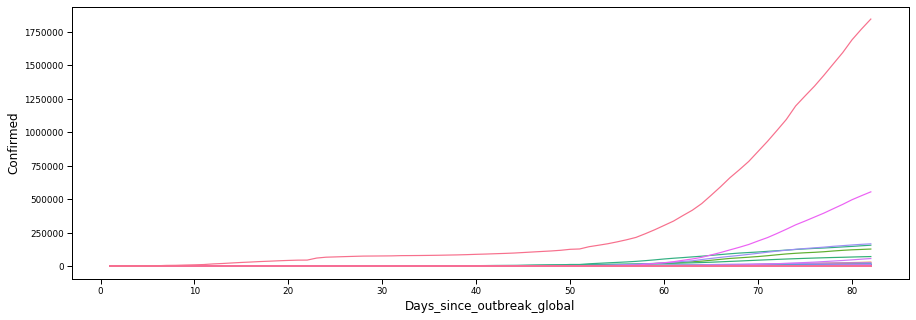

In [532]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    73  \
Country                                                             ...         
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...   281   
Albania                      0   0   0   0   0   0   0   0   0   0  ...   304   
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  1171   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   439   
Angola                       0   0   0   0   0   0   0   0   0   0  ...     8   

Days_since_outbreak_global    74    75    76    77    78    79    80    81  \
Country                                                                      
Afghanistan                  299   349   367   423   444   484   521   555   
Albania                      333   361   377   383   400   409   416   433   
Algeria                     1251  1320  1423  1468  1572  1666  1761  1825   
Andorra                      466   501   5

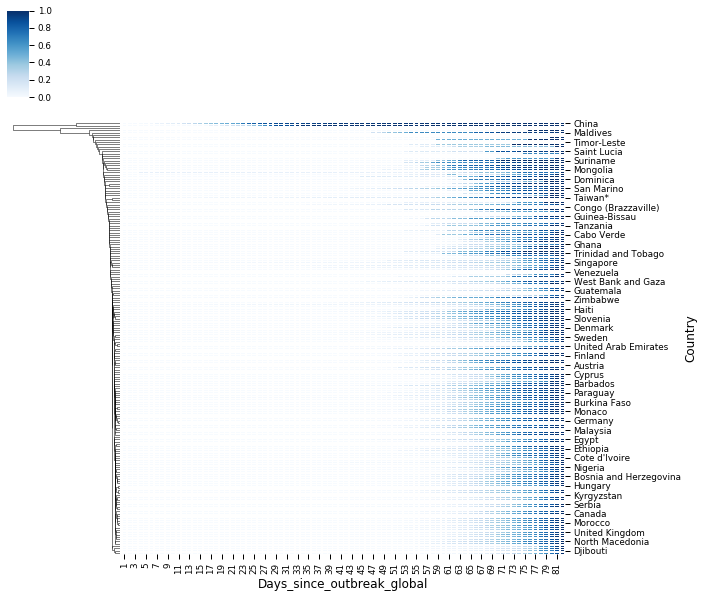

<Figure size 1800x576 with 0 Axes>

In [533]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [534]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep=False)
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
176,275,PS,PSE,275.00,nan,NaN,NaN,West Bank and Gaza,31.95,35.23,West Bank and Gaza,5101416.00
177,732,EH,ESH,732.00,nan,NaN,NaN,Western Sahara,24.22,-12.89,Western Sahara,597330.00
178,887,YE,YEM,887.00,nan,NaN,NaN,Yemen,15.55,48.52,Yemen,29825968.00
179,894,ZM,ZMB,894.00,nan,NaN,NaN,Zambia,-13.13,27.85,Zambia,18383956.00


In [535]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1,Afghanistan,AF
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1,Albania,AL
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1,Algeria,DZ
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1,Andorra,AD
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1,Angola,AO
...,...,...,...,...,...,...,...,...,...,...
21725,1511104,Worldwide,2020-04-08,nan,nan,NaN,Worldwide,78,NaN,NaN
21726,1595350,Worldwide,2020-04-09,nan,nan,NaN,Worldwide,79,NaN,NaN
21727,1691719,Worldwide,2020-04-10,nan,nan,NaN,Worldwide,80,NaN,NaN
21728,1771514,Worldwide,2020-04-11,nan,nan,NaN,Worldwide,81,NaN,NaN


In [536]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Continent                                                           ...   
Africa                       0   0   0   0   0   0   0   0   0   0  ...   
Asia                         6  10  17  23  30  35  49  56  67  87  ...   
Europe                       0   0   0   0   0   1   4   5   5  11  ...   
North America                0   0   0   0   0   0   0   0   0   0  ...   
Oceania                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global      73      74      75      76      77      78  \
Continent                                                                    
Africa                        7913    8592    9302   10003   10636   11440   
Asia                        122427  131340  140605  151188  160616  170099   
Europe                      453425  478573  500279  519358  540541  565342   
North America                 5787    6289    6951    7575    8217    8989   
Oceani

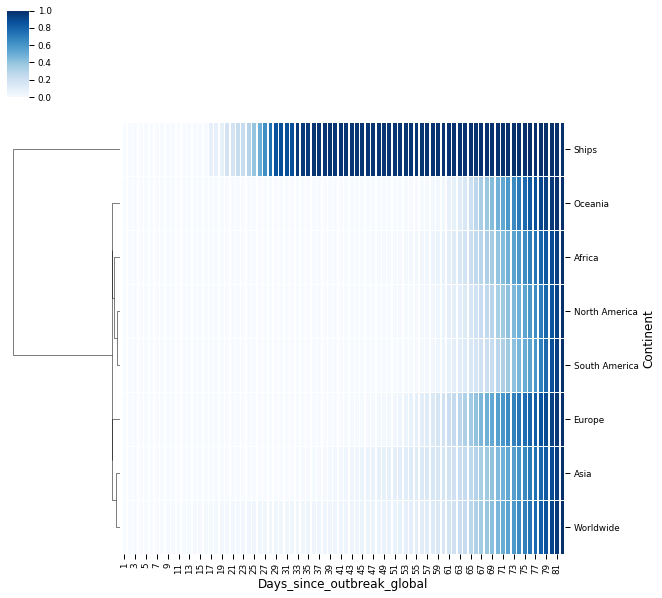

<Figure size 1800x576 with 0 Axes>

In [537]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   73  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  281   
Armenia                      0   0   0   0   0   0   0   0   0   0  ...  736   
Azerbaijan                   0   0   0   0   0   0   0   0   0   0  ...  443   
Bahrain                      0   0   0   0   0   0   0   0   0   0  ...  672   
Bangladesh                   0   0   0   0   0   0   0   0   0   0  ...   61   

Days_since_outbreak_global   74   75   76   77   78   79   80    81    82  
Country                                                                    
Afghanistan                 299  349  367  423  444  484  521   555   607  
Armenia                     770  822  833  853  881  921  937   967  1013  
Azerbaijan                  521  584  641  717  822  926  991  1058  1098  
Bahrain                     688  700  756  811  823  887  9

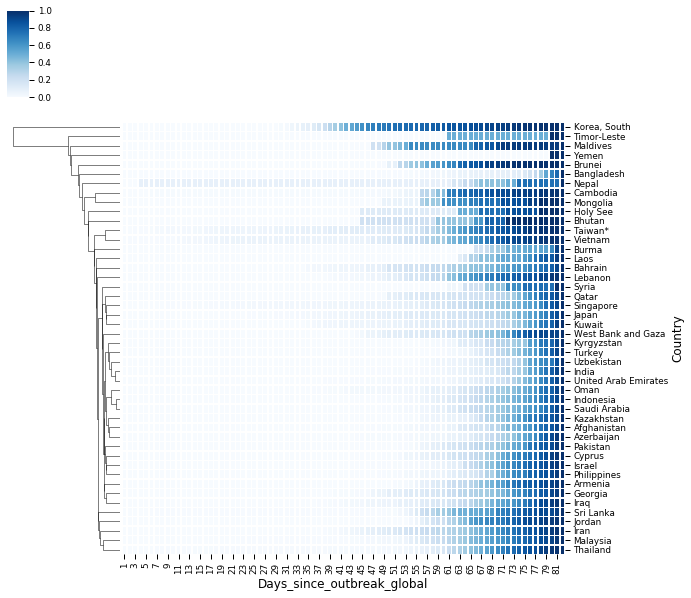

<Figure size 1800x576 with 0 Axes>

In [538]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Country                                                             ...   
Albania                      0   0   0   0   0   0   0   0   0   0  ...   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   
Austria                      0   0   0   0   0   0   0   0   0   0  ...   
Belarus                      0   0   0   0   0   0   0   0   0   0  ...   
Belgium                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global     73     74     75     76     77     78     79  \
Country                                                                       
Albania                       304    333    361    377    383    400    409   
Andorra                       439    466    501    525    545    564    583   
Austria                     11524  11781  12051  12297  12639  12942  13244   
Belarus                       351    440    562    700    861   1066   1486   


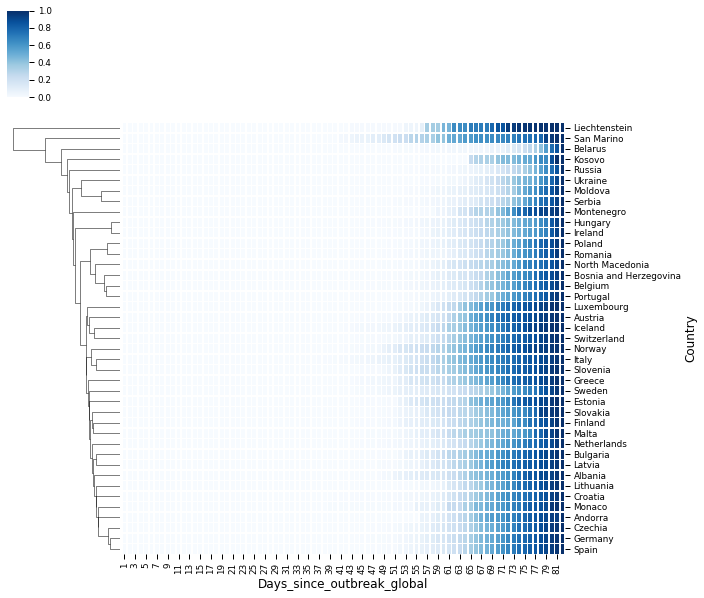

<Figure size 1800x576 with 0 Axes>

In [539]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    73  \
Country                                                             ...         
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  1171   
Angola                       0   0   0   0   0   0   0   0   0   0  ...     8   
Benin                        0   0   0   0   0   0   0   0   0   0  ...    16   
Botswana                     0   0   0   0   0   0   0   0   0   0  ...     4   
Burkina Faso                 0   0   0   0   0   0   0   0   0   0  ...   302   

Days_since_outbreak_global    74    75    76    77    78    79    80    81  \
Country                                                                      
Algeria                     1251  1320  1423  1468  1572  1666  1761  1825   
Angola                        10    14    16    17    19    19    19    19   
Benin                         16    22    26    26    26    26    35    35   
Botswana                       4     6    

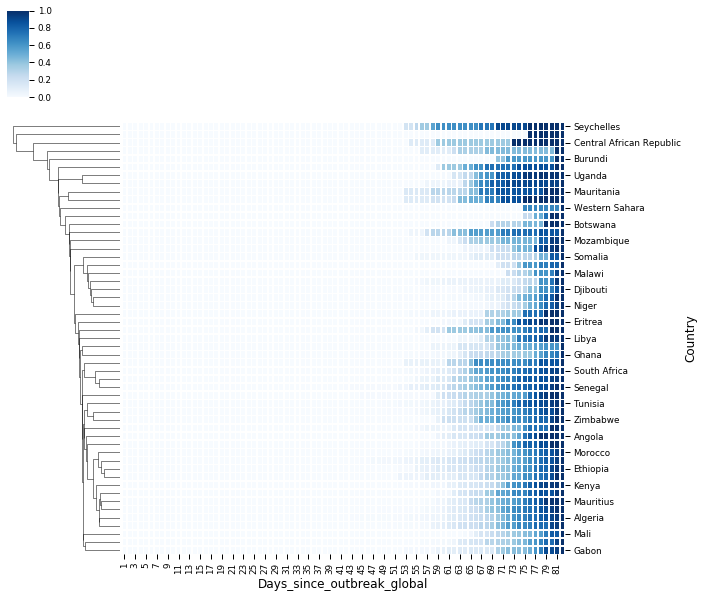

<Figure size 1800x576 with 0 Axes>

In [540]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   73  \
Country                                                             ...        
Antigua and Barbuda          0   0   0   0   0   0   0   0   0   0  ...   15   
Bahamas                      0   0   0   0   0   0   0   0   0   0  ...   24   
Barbados                     0   0   0   0   0   0   0   0   0   0  ...   51   
Belize                       0   0   0   0   0   0   0   0   0   0  ...    4   
Costa Rica                   0   0   0   0   0   0   0   0   0   0  ...  416   

Days_since_outbreak_global   74   75   76   77   78   79   80   81   82  
Country                                                                  
Antigua and Barbuda          15   15   15   19   19   19   19   21   21  
Bahamas                      28   28   29   33   40   41   42   46   46  
Barbados                     52   56   60   63   63   66   67   68   71  
Belize                        4    5    7    7    8    9   10   13   

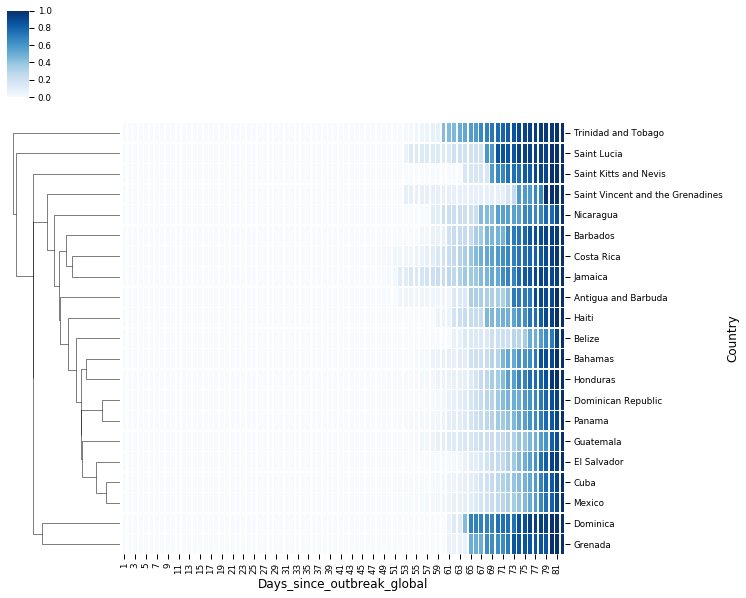

<Figure size 1800x576 with 0 Axes>

In [541]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   73  \
Country                                                             ...        
Fiji                         0   0   0   0   0   0   0   0   0   0  ...    7   
New Zealand                  0   0   0   0   0   0   0   0   0   0  ...  868   
Papua New Guinea             0   0   0   0   0   0   0   0   0   0  ...    1   

Days_since_outbreak_global   74    75    76    77    78    79    80    81  \
Country                                                                     
Fiji                         12    12    14    15    15    15    16    16   
New Zealand                 950  1039  1106  1160  1210  1239  1283  1312   
Papua New Guinea              1     1     2     2     2     2     2     2   

Days_since_outbreak_global    82  
Country                           
Fiji                          16  
New Zealand                 1330  
Papua New Guinea               2  

[3 rows x 82 columns]


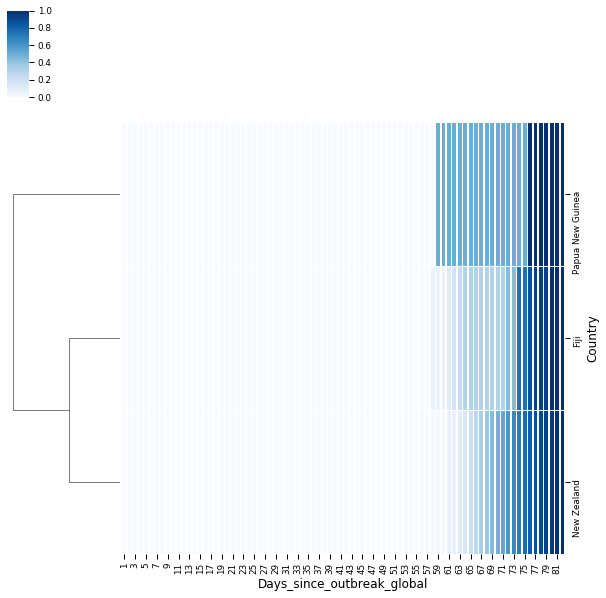

<Figure size 1800x576 with 0 Axes>

In [542]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    73  \
Country                                                             ...         
Argentina                    0   0   0   0   0   0   0   0   0   0  ...  1265   
Bolivia                      0   0   0   0   0   0   0   0   0   0  ...   132   
Brazil                       0   0   0   0   0   0   0   0   0   0  ...  9056   
Chile                        0   0   0   0   0   0   0   0   0   0  ...  3737   
Colombia                     0   0   0   0   0   0   0   0   0   0  ...  1267   

Days_since_outbreak_global     74     75     76     77     78     79     80  \
Country                                                                       
Argentina                    1451   1451   1554   1628   1715   1795   1975   
Bolivia                       139    157    183    194    210    264    268   
Brazil                      10360  11130  12161  14034  16170  18092  19638   
Chile                        4161   4

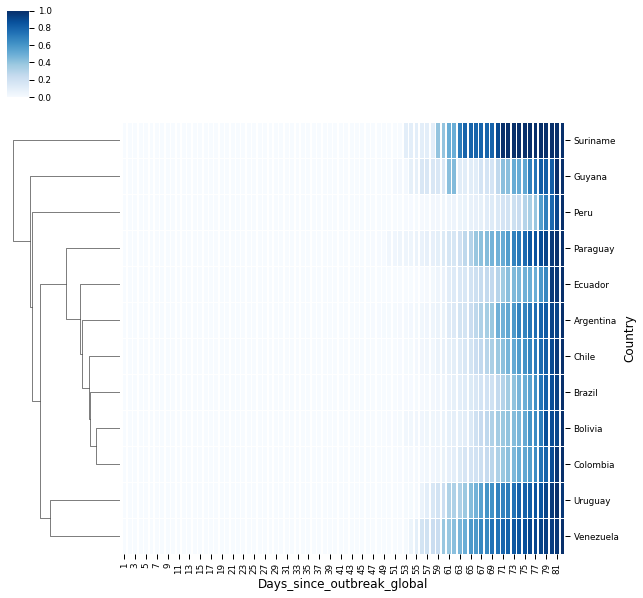

<Figure size 1800x576 with 0 Axes>

In [543]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [544]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2,Continent,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Afghanistan,2020-01-22,33.00,65.00,0,Afghanistan,1,Afghanistan,AF,Asia,22,2,4,1,1,2020,0.00,0.00
1,0,Albania,2020-01-22,41.15,20.17,0,Albania,1,Albania,AL,Europe,22,2,4,1,1,2020,0.00,0.00
2,0,Algeria,2020-01-22,28.03,1.66,0,Algeria,1,Algeria,DZ,Africa,22,2,4,1,1,2020,0.00,0.00
3,0,Andorra,2020-01-22,42.51,1.52,0,Andorra,1,Andorra,AD,Europe,22,2,4,1,1,2020,0.00,0.00
4,0,Angola,2020-01-22,-11.20,17.87,0,Angola,1,Angola,AO,Africa,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21725,1511104,Worldwide,2020-04-08,0.00,0.00,0,Worldwide,78,0,0,Worldwide,8,2,15,2,4,2020,1426096.00,85008.00
21726,1595350,Worldwide,2020-04-09,0.00,0.00,0,Worldwide,79,0,0,Worldwide,9,3,15,2,4,2020,1511104.00,84246.00
21727,1691719,Worldwide,2020-04-10,0.00,0.00,0,Worldwide,80,0,0,Worldwide,10,4,15,2,4,2020,1595350.00,96369.00
21728,1771514,Worldwide,2020-04-11,0.00,0.00,0,Worldwide,81,0,0,Worldwide,11,5,15,2,4,2020,1691719.00,79795.00


In [545]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     73    74    75     76    77     78    79  \
Country                     ...                                                
Afghanistan                 ...   8.00 18.00 50.00  18.00 56.00  21.00 40.00   
Albania                     ...  27.00 29.00 28.00  16.00  6.00  17.00  9.00   
Algeria                     ... 185.00 80.00 69.00 103.00 45.00 104.00 94.00   
Andorra                     ...  11.00 

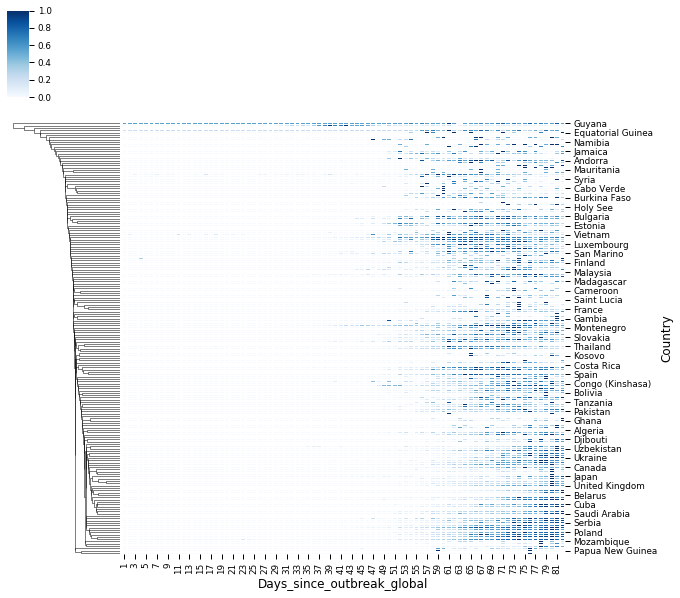

<Figure size 1800x576 with 0 Axes>

In [546]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1     2      3      4      5      6       7   \
Continent                                                                   
0                          0.00 95.00 280.00 487.00 677.00 803.00 2634.00   
Africa                     0.00  0.00   0.00   0.00   0.00   0.00    0.00   
Asia                       0.00  4.00   7.00   6.00   7.00   5.00   14.00   
Europe                     0.00  0.00   0.00   0.00   0.00   1.00    3.00   
North America              0.00  0.00   0.00   0.00   0.00   0.00    0.00   

Days_since_outbreak_global     8       9       10  ...       73       74  \
Continent                                          ...                     
0                          580.00 2057.00 1667.00  ... 43432.00 63817.00   
Africa                       0.00    0.00    0.00  ...   881.00   679.00   
Asia                         7.00   11.00   20.00  ...  8567.00  8913.00   
Europe                       1.00    0.00    6.00  ... 26991.00 25148.00   
Nort

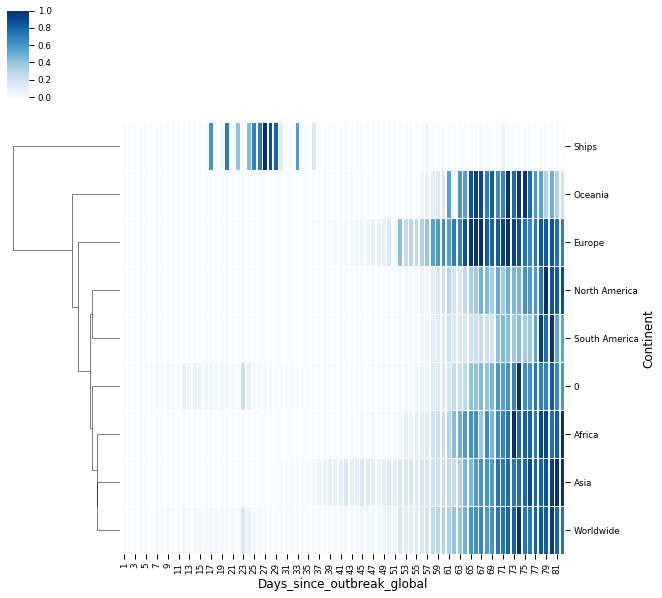

<Figure size 1800x576 with 0 Axes>

In [547]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    73    74    75    76    77     78     79  \
Country                     ...                                               
Afghanistan                 ...  8.00 18.00 50.00 18.00 56.00  21.00  40.00   
Armenia                     ... 73.00 34.00 52.00 11.00 20.00  28.00  40.00   
Azerbaijan                  ... 43.00 78.00 63.00 57.00 76.00 105.00 104.00   
Bahrain                     ... 29.00 16.00 

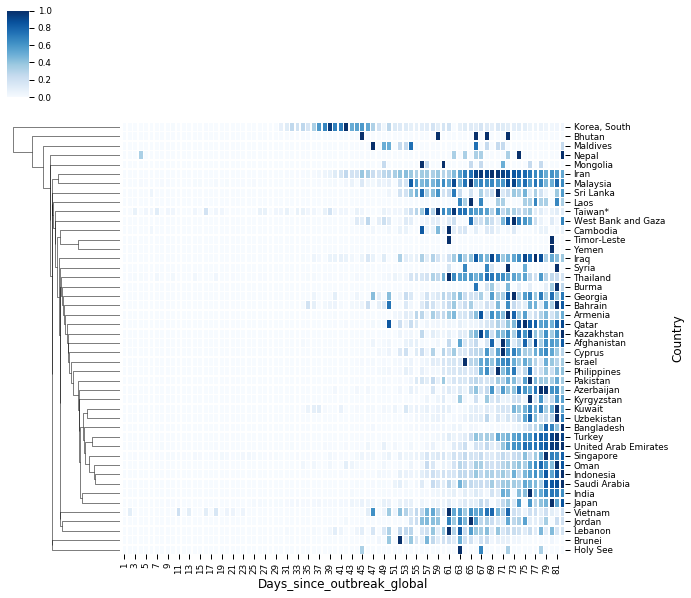

<Figure size 1800x576 with 0 Axes>

In [548]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      73      74      75      76      77  \
Country                     ...                                           
Albania                     ...   27.00   29.00   28.00   16.00    6.00   
Andorra                     ...   11.00   27.00   35.00   24.00   20.00   
Austria                     ...  395.00  257.00  270.00  246.00  342.00   
Belarus                     ...   47.00   89.00  122.00  138.00 

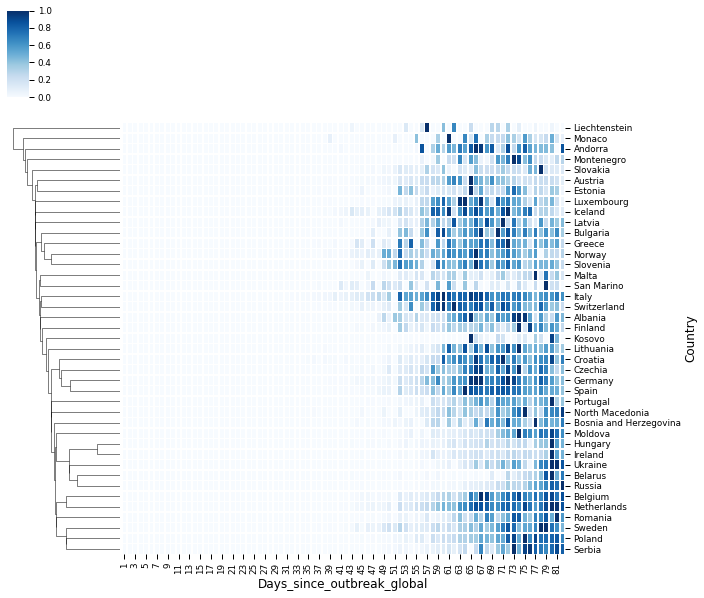

<Figure size 1800x576 with 0 Axes>

In [549]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     73    74    75     76    77     78    79  \
Country                     ...                                                
Algeria                     ... 185.00 80.00 69.00 103.00 45.00 104.00 94.00   
Angola                      ...   0.00  2.00  4.00   2.00  1.00   2.00  0.00   
Benin                       ...   3.00  0.00  6.00   4.00  0.00   0.00  0.00   
Botswana                    ...   0.00 

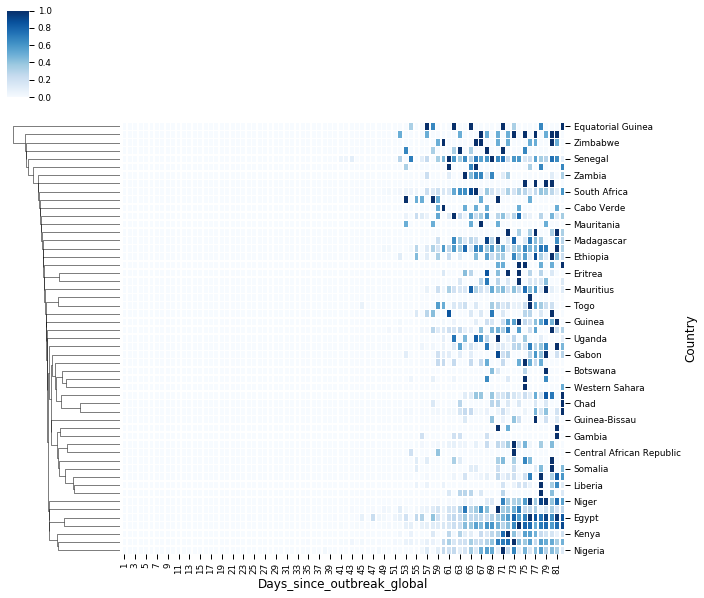

<Figure size 1800x576 with 0 Axes>

In [550]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Costa Rica                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    73    74    75    76    77    78    79  \
Country                     ...                                             
Antigua and Barbuda         ...  6.00  0.00  0.00  0.00  4.00  0.00  0.00   
Bahamas                     ...  0.00  4.00  0.00  1.00  4.00  7.00  1.00   
Barbados                    ...  5.00  1.00  4.00  4.00  3.00  0.00  3.00   
Belize                      ...  1.00  0.00  1.00  2.0

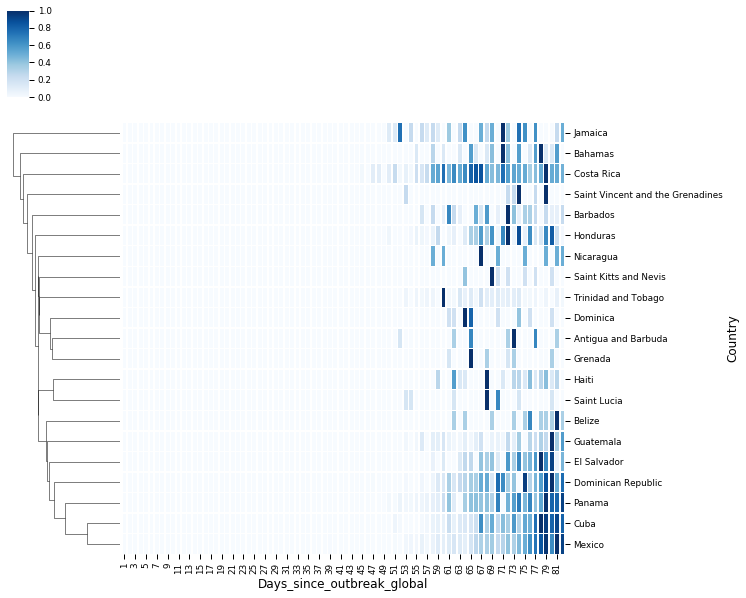

<Figure size 1800x576 with 0 Axes>

In [551]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Papua New Guinea           0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    73    74    75    76    77    78    79  \
Country                     ...                                             
Fiji                        ...  0.00  5.00  0.00  2.00  1.00  0.00  0.00   
New Zealand                 ... 71.00 82.00 89.00 67.00 54.00 50.00 29.00   
Papua New Guinea            ...  0.00  0.00  0.00  1.00  0.00  0.00  0.00   

Days_since_outbreak_global    80    81    82  
Country                                       
Fiji                        1.00  0.00  0.00  
New Zealand                44.00 29.00 18.00  
Papua New Guinea         

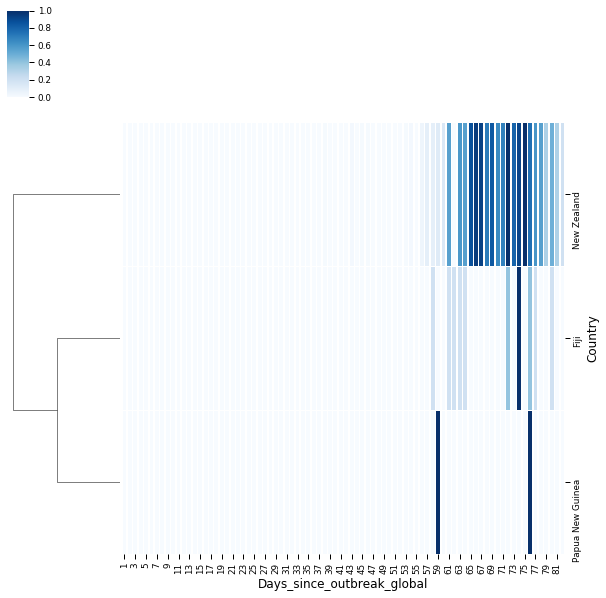

<Figure size 1800x576 with 0 Axes>

In [552]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      73      74     75      76      77  \
Country                     ...                                          
Argentina                   ...  132.00  186.00   0.00  103.00   74.00   
Bolivia                     ...    9.00    7.00  18.00   26.00   11.00   
Brazil                      ... 1012.00 1304.00 770.00 1031.00 1873.00   
Chile                       ...  333.00  424.00 310.00  344.00  301.0

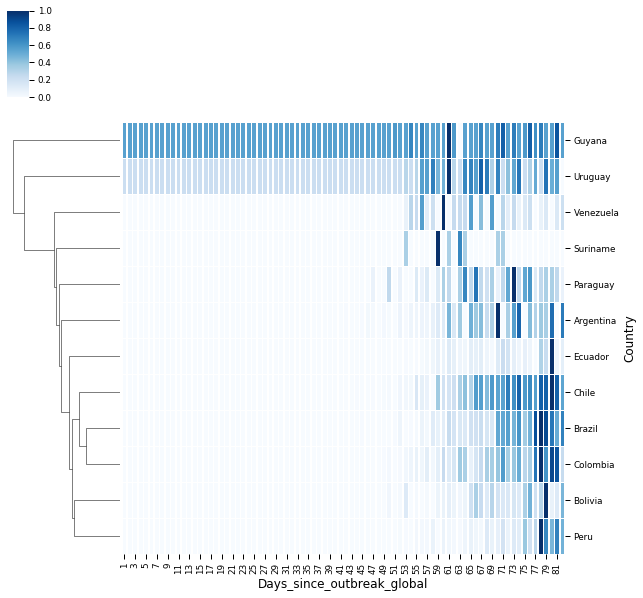

<Figure size 1800x576 with 0 Axes>

In [553]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [554]:
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country']]
df_ml_confirmed

,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country
0,0.00,Afghanistan,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
1,0.00,Albania,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
2,0.00,Algeria,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
3,0.00,Andorra,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
4,0.00,Angola,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
21725,85008.00,Worldwide,78,2020-04-08,8,2,15,2,4,2020,75118.00,77.00
21726,84246.00,Worldwide,79,2020-04-09,9,3,15,2,4,2020,80861.00,78.00
21727,96369.00,Worldwide,80,2020-04-10,10,4,15,2,4,2020,82451.00,79.00
21728,79795.00,Worldwide,81,2020-04-11,11,5,15,2,4,2020,101491.00,80.00


In [555]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [556]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 4, 5, 11, 19, 13, 404130)

In [557]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [558]:
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

1525.2399398170087
1717.2005359270656
0.38114663135363075


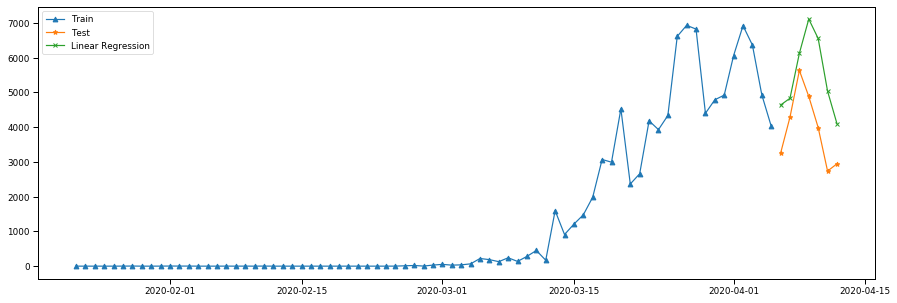

In [559]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

948.4187397571324
1148.664791758885
0.3008484154073656


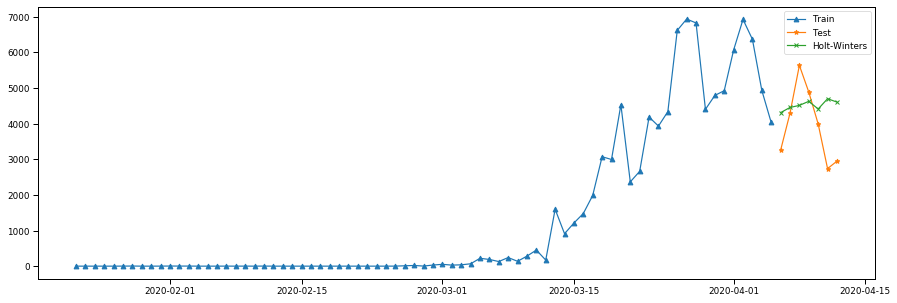

In [560]:
#Holt winters-non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

['add', True, 'add', 6, False, False]
820.7452537122851
946.5546785289218
0.24932264806491272


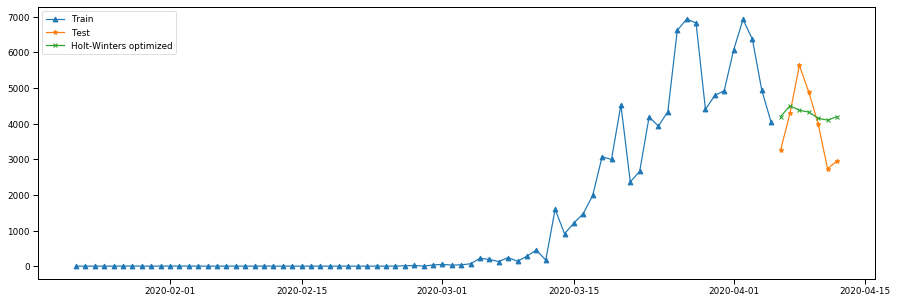

In [575]:
#Holt Winters optimized
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    try:
        cg = cfg_list[j]
        t,d,s,p,b,r = cg

        model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)

        hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

        pred = hw_model.predict(start=test.index[0], end=test.index[-1])

        pred = pd.DataFrame(pred)
        pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)
        
        rmse = np.sqrt(mean_squared_error(y_pred=pred, y_true=test))
        
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

t1,d1,s1,p1,b1,r1 = best_config
print(best_config)

if t1 == None:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

pred = hw_model.predict(start=test.index[0], end=test.index[-1])

pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

1284.6682275750652
1557.5765823683066
0.37653065214579057


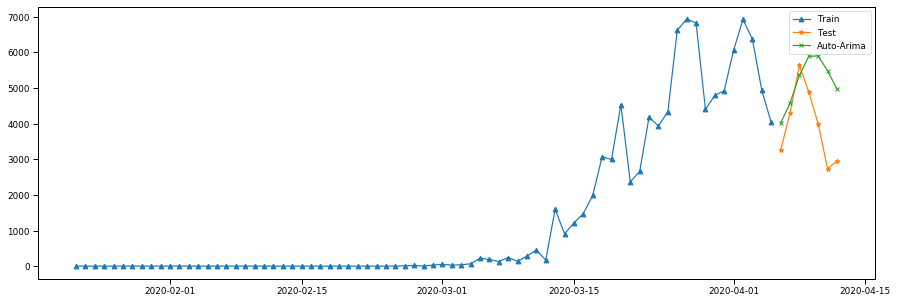

In [574]:
#Auto-Arima
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

775.69384765625
922.5161187485088
0.234604553619231


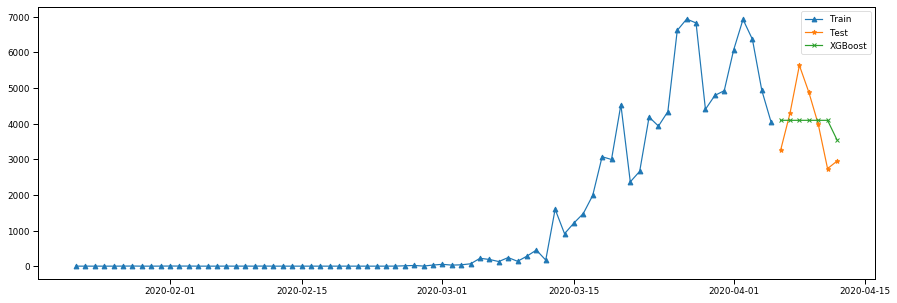

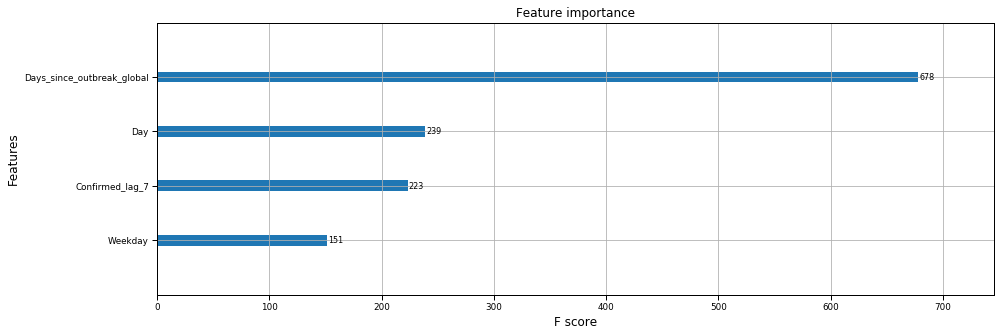

In [576]:
#XGBoost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 7568 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 13168 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 13500 out of 13500 | elapsed:   12.0s finished


1668.7642996651787
1905.8127716694464
0.4486210896003934


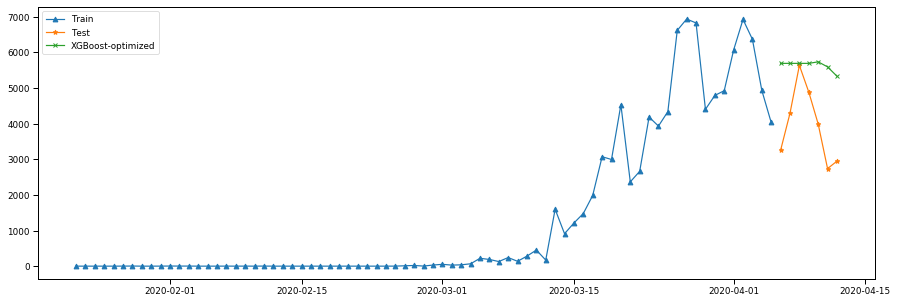

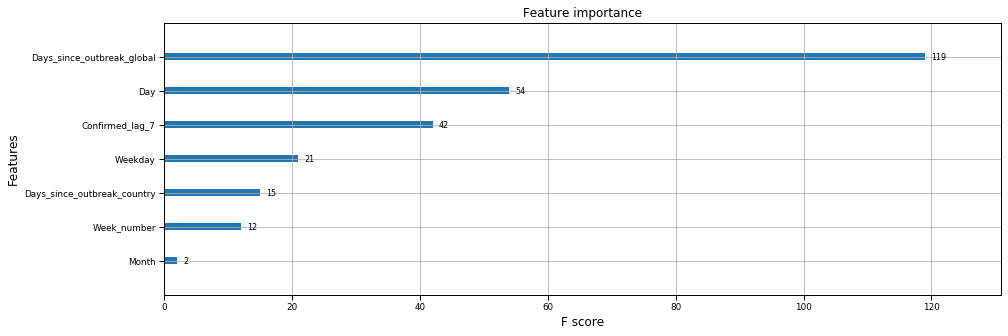

In [577]:
#XGBoost optimized
param_test = {
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth':[4,5,6],
 'min_child_weight':[6,8,10,12],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=47, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27), 
 param_grid = param_test, n_jobs=-1, iid=False, cv=5, verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

best_params_xgb = gsearch.best_estimator_.get_xgb_params()
xgtrain = xgb.DMatrix(data=X_train,label=y_train)
xgtest = xgb.DMatrix(X_test)
cvresult = xgb.cv(best_params_xgb, xgtrain, num_boost_round=gsearch.best_estimator_.get_xgb_params()['n_estimators'], nfold=5,
            metrics='rmse', early_stopping_rounds=200)
gsearch.best_estimator_.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
gsearch.best_estimator_.fit(X_train, y_train,eval_metric='rmse')

Confirmed_test['Confirmed_Prediction'] = gsearch.best_estimator_.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost-optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(gsearch.best_estimator_)
pyplot.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

746.682104434456
867.4801298389131
0.2287569212601405


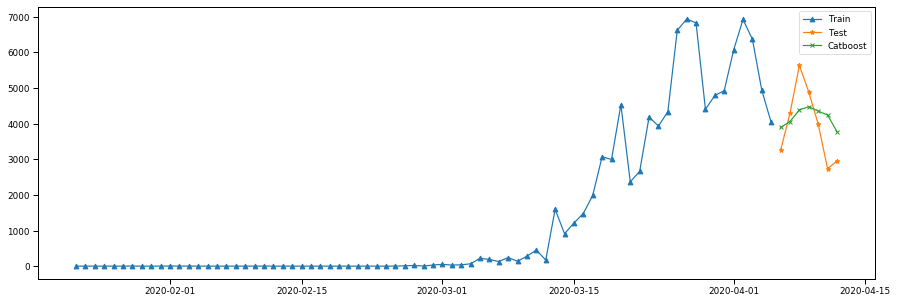

In [685]:
#Catboost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = CatBoostRegressor(iterations=1000, verbose=False, loss_function='RMSE')
# Fit model
model.fit(X_train, y_train,plot=True, eval_set=(X_test, y_test))

Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Catboost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2926.041245709217
3127.2391202806493
0.6374112755484183


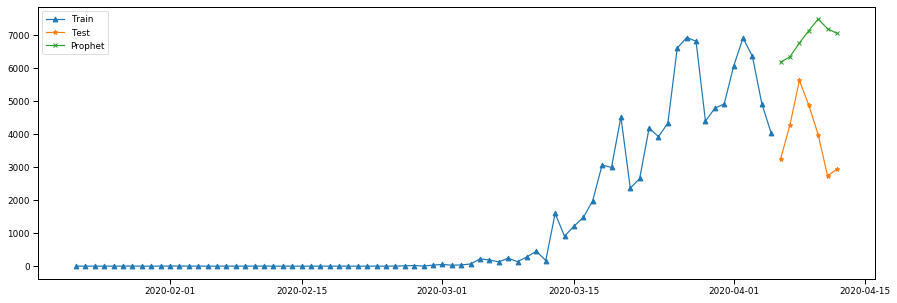

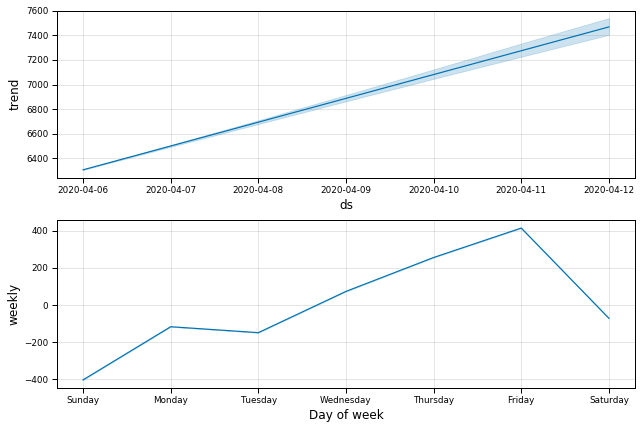

In [597]:
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = train[['Confirmed','Date']]
test = test[['Confirmed','Date']]

model = Prophet()
model.fit(train.reset_index().rename(columns={'Date':'ds', 'Confirmed':'y'}))

#pred = model.predict(df=test.reset_index().rename(columns={'Date':'ds'}))
pred = pd.DataFrame(model.predict(df=test.reset_index().rename(columns={'Date':'ds'})))

#pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)

test = test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

plt.plot(train.Date, train.Confirmed, label='Train',marker ='^')
plt.plot(test.Date, test.Confirmed, label='Test', marker = "*")
plt.plot(test.Date, pred.yhat, label='Prophet', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred.yhat, y_true=test.Confirmed))
print(np.sqrt(mean_squared_error(y_pred=pred.yhat, y_true=test.Confirmed)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.yhat))

fig = model.plot_components(pred)

### All customers

In [683]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Canada_Diamond Princess")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)
len(df_ml_confirmed_var)

265

#### Linear Regression

In [639]:
Train_and_Test = []

In [640]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [641]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSLE.notnull(), 'RMSLE']))

300.7941952493911
369.5562486650445
0.7410420839102863


#### Holt-Winters (non-optimized)

In [642]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [643]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSLE.notnull(), 'RMSLE']))

182.74422703213443
210.05640448329925
0.7788425570030598


#### Holt-Winters (optimized)

In [644]:
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

In [645]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    best_RMSE = np.inf
    best_config = []
    t1 = d1 = s1 = p1 = b1 = r1 = ''
    for j in range(len(cfg_list)):
        try:
            cg = cfg_list[j]
            t,d,s,p,b,r = cg

            model = ExponentialSmoothing(Confirmed_train_, trend=t, damped=d, seasonal=s, seasonal_periods=p)

            hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

            Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])

            rmse = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = cfg_list[j]
        except:
            continue

    t1,d1,s1,p1,b1,r1 = best_config

    if t1 == None:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1)
    else:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

    hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [646]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSLE.notnull(), 'RMSLE']))

79.69702819008774
100.89871305209802
0.6445873996652888


#### Auto-ARIMA

In [647]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                          suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [648]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSLE.notnull(), 'RMSLE']))

197.54395887742845
224.7597809871317
0.7432593833595447


#### XGboost (non-optimized)

In [649]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Non-optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost)


Finished!


In [650]:
Train_and_Test_XGBoost = Train_and_Test_XGBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSLE.notnull(), 'RMSLE']))

79.19714385566685
100.6351992275611
0.6188869884684028


#### XGboost (optimized)

In [651]:
param_test = {
     'gamma':[i/10.0 for i in range(0,5)],
     'max_depth':[4,5,6],
     'min_child_weight':[6,8,10,12],
     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
     'subsample':[i/100.0 for i in range(75,90,5)],
     'colsample_bytree':[i/100.0 for i in range(75,90,5)],
     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
    }

In [652]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    gsearch = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=47, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
     objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27), 
     param_grid = param_test, n_jobs=-1, iid=False, cv=5, verbose=0)
    gsearch.fit(X_train, y_train)
    gsearch.best_params_, gsearch.best_score_

    best_params_xgb = gsearch.best_estimator_.get_xgb_params()
    xgtrain = xgb.DMatrix(data=X_train,label=y_train)
    xgtest = xgb.DMatrix(X_test)
    cvresult = xgb.cv(best_params_xgb, xgtrain, num_boost_round=gsearch.best_estimator_.get_xgb_params()['n_estimators'], nfold=5,
                metrics='rmse', early_stopping_rounds=200)
    gsearch.best_estimator_.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    gsearch.best_estimator_.fit(X_train, y_train,eval_metric='rmse')

    Confirmed_test['Confirmed_Prediction'] = gsearch.best_estimator_.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost_optimized)


Finished!


In [653]:
Train_and_Test_XGBoost_optimized = Train_and_Test_XGBoost_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSLE.notnull(), 'RMSLE']))

114.34590125496818
137.76542919002034
0.7639880118563722


#### CatBoost

In [684]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    try:
    
        List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]

        Confirmed_train = List.loc[List.Date <= split_date].copy()
        Confirmed_test = List.loc[List.Date > split_date].copy()

        X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
        X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        model = CatBoostRegressor(iterations=1000, verbose=False)
        model.fit(X_train, y_train)

        Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

        Confirmed_test['File_type'] = "Test"
        Confirmed_train['File_type'] = "Train"

        Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)

        Train_and_Test_['Model'] = 'CatBoost'

        Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

        Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

        Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])

        Train_and_Test_temp.append(Train_and_Test_)
        
    except Exception as e: 
        pass
    
print("Finished!")

Train_and_Test_CatBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_CatBoost)


Finished!


In [686]:
Train_and_Test_CatBoost = Train_and_Test_CatBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSLE.notnull(), 'RMSLE']))

132.6434434638733
158.49562992265805
0.7933390961824944


#### Prophet

In [690]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)
    
    Confirmed_train_ = Confirmed_train[['Confirmed','Date']]
    Confirmed_test_ = Confirmed_test[['Confirmed','Date']]

    model = Prophet()
    model.fit(Confirmed_train_.reset_index(drop=True).rename(columns={'Date':'ds', 'Confirmed':'y'}))

    Confirmed_pred = model.predict(df=Confirmed_test_.reset_index(drop=True).rename(columns={'Date':'ds'}))
    
    Confirmed_test.index.name = None
    Confirmed_test = pd.merge(Confirmed_test, Confirmed_pred[['ds','yhat']], left_on='Date', right_on='ds', how='left').rename(columns={'yhat':'Confirmed_Prediction'}).drop(columns=['ds'])
            
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Prophet"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Prophet = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Prophet)

[13/Apr/2020 17:41:22] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:41:22] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:41:26] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:41:26] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:41:29] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:41:29] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:41:32] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:41:32] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:41:35] INFO - Disabling yearly seasonali

[13/Apr/2020 17:43:21] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:43:21] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:43:24] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:43:24] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:43:27] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:43:27] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:43:30] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:43:30] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:43:33] INFO - Disabling yearly seasonali

[13/Apr/2020 17:45:09] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:45:09] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:45:11] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:45:11] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:45:14] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:45:14] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:45:17] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:45:17] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:45:20] INFO - Disabling yearly seasonali

[13/Apr/2020 17:46:57] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:46:57] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:47:00] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:47:00] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:47:03] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:47:03] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:47:06] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:47:06] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:47:09] INFO - Disabling yearly seasonali

[13/Apr/2020 17:48:46] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:48:46] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:48:49] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:48:49] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:48:53] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:48:53] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:48:56] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:48:56] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:48:59] INFO - Disabling yearly seasonali

[13/Apr/2020 17:50:41] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:50:41] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:50:44] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:50:44] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:50:47] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:50:47] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:50:51] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:50:51] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:50:54] INFO - Disabling yearly seasonali

[13/Apr/2020 17:52:34] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:52:34] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:52:37] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:52:37] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:52:40] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:52:40] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:52:43] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:52:43] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:52:47] INFO - Disabling yearly seasonali

[13/Apr/2020 17:54:24] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:54:24] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:54:28] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:54:28] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:54:31] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:54:31] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:54:34] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[13/Apr/2020 17:54:34] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[13/Apr/2020 17:54:38] INFO - Disabling yearly seasonali

In [691]:
Train_and_Test_Prophet = Train_and_Test_Prophet.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSLE.notnull(), 'RMSLE']))

207.61264575806513
229.92878201981867
0.7601085463687134


#### Final Steps

In [694]:
Train_and_Test['Update_date'] = datetime.today()

In [695]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')

In [696]:
Train_and_Test.to_excel('C:/Users/xxx/Google Drive/Train_and_Test.xlsx', index = False)